In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import OLS

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
BASE_COLOR = sns.color_palette()[0]
TEST_SIZE = 0.2
RANDOM_STATE = 42
BATCH_SIZE = 32
LR = 0.01

# Load train and test Datasets

In [4]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [5]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Wrangle train Dataset

## Dropping NaN values

droping NaN value with as follows:
 - if column has NaN values more than 200 entry will drop that column
 - if column has NaN values less than 200:
 - if column is numeric will fillna with the `mean`
 - if column is categorical will dropit

In [6]:
nan_cols = train_df.isna().sum()
nan_cols = nan_cols[nan_cols > 0]
nan_cols

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [7]:
nan_cols_to_drop = nan_cols[nan_cols > 200]
train_df = train_df.drop(nan_cols_to_drop.index.values, axis='columns')
train_df.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [8]:
nan_cols = train_df.isna().sum()
nan_cols = nan_cols[nan_cols > 0]
# nan_cols
non_numeric_nan_cols = train_df[nan_cols.index.values].select_dtypes('object').columns
non_numeric_nan_cols

Index(['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond'],
      dtype='object')

In [9]:
train_df = train_df.drop(non_numeric_nan_cols, axis="columns")
train_df.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


## Checking any duplicates

In [10]:
train_df[train_df.duplicated()]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


**No Duplicated** row in the dataset

In [11]:
nan_cols = train_df.isna().sum()
nan_cols = nan_cols[nan_cols > 0]
nan_cols

MasVnrArea      8
GarageYrBlt    81
dtype: int64

In [12]:
train_df['MasVnrArea'].fillna(train_df['MasVnrArea'].mean(), inplace=True)
train_df['GarageYrBlt'].fillna(train_df['GarageYrBlt'].mean(), inplace=True)

nan_cols = train_df.isna().sum()
nan_cols = nan_cols[nan_cols > 0]

assert len(nan_cols) == 0

## Inspecting Categorical Columns

In [13]:
numeric_cols = train_df.select_dtypes('number').columns
categorical_cols = train_df.select_dtypes('object').columns

In [14]:
numeric_cols

Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [15]:
categorical_cols

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating',
       'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

### MSZoning Analysis

In [16]:
train_df['MSZoning'].value_counts(normalize=True).sort_values(ascending=False)

RL         0.788356
RM         0.149315
FV         0.044521
RH         0.010959
C (all)    0.006849
Name: MSZoning, dtype: float64

**MSZoning** has a hig bias twards the **Residential Low Density** and **Residential Medium Density** zoning types.

### HouseStyle Analysis

In [17]:
train_df['HouseStyle'].value_counts(normalize=True).sort_values(ascending=False)

1Story    0.497260
2Story    0.304795
1.5Fin    0.105479
SLvl      0.044521
SFoyer    0.025342
1.5Unf    0.009589
2.5Unf    0.007534
2.5Fin    0.005479
Name: HouseStyle, dtype: float64

**HouseStyle** has major proportions twards **One Story**, **Two Story** and **One and one-half story: 2nd level unfinished**

### Functional Analysis

In [18]:
train_df['Functional'].value_counts(normalize=True).sort_values(ascending=False)

Typ     0.931507
Min2    0.023288
Min1    0.021233
Mod     0.010274
Maj1    0.009589
Maj2    0.003425
Sev     0.000685
Name: Functional, dtype: float64

**Functional** column has large proportion twards **Typical Functionality**

### SaleCondition Analysis

In [19]:
train_df['SaleCondition'].value_counts(normalize=True).sort_values(ascending=False)

Normal     0.820548
Partial    0.085616
Abnorml    0.069178
Family     0.013699
Alloca     0.008219
AdjLand    0.002740
Name: SaleCondition, dtype: float64

**SaleCondition** has large proportion in being **Normal**

### Heating Analysis

In [20]:
train_df['Heating'].value_counts(normalize=True).sort_values(ascending=False)

GasA     0.978082
GasW     0.012329
Grav     0.004795
Wall     0.002740
OthW     0.001370
Floor    0.000685
Name: Heating, dtype: float64

**Heating** columns has large proportion twards **Gas forced warm air furnace**

## Cleaning Categorical Columns

In [21]:
## MSZoning Column
train_df['zone_low_density'] = train_df['MSZoning'] == "RL"

## HouseStyle Column
train_df['one_story_style'] = train_df['HouseStyle'] == '1Story'
train_df['two_story_style'] = train_df['HouseStyle'] == '2Story'
train_df['one_half_story_style'] = train_df['HouseStyle'] == '1.5Fin'

## Functional Column
train_df['typical_functionality'] = train_df['Functional'] == 'Typ'

## Sale Condition
train_df['sale_normal_condition'] = train_df['SaleCondition'] == 'Normal'

## Heating Column
train_df['gas_heating'] = train_df['Heating'] == 'GasA'

## conver to numeric values
cols = ['zone_low_density', 'one_story_style', 'two_story_style', 'typical_functionality',
        'one_half_story_style', 'gas_heating', 'sale_normal_condition']

train_df[cols] = train_df[cols].astype('int')

train_df[
    ['zone_low_density', 'one_story_style', 'two_story_style', 'typical_functionality',
     'one_half_story_style', 'gas_heating', 'sale_normal_condition']
].head()

,zone_low_density,one_story_style,two_story_style,typical_functionality,one_half_story_style,gas_heating,sale_normal_condition
0,1,0,1,1,0,1,1
1,1,1,0,1,0,1,1
2,1,0,1,1,0,1,1
3,1,0,1,1,0,1,0
4,1,0,1,1,0,1,1


## Inspecting Numerical Columns

In [22]:
numeric_cols

Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

### MSSubClass Analysis
 - **20	1-STORY 1946 & NEWER ALL STYLES**
 - 30	1-STORY 1945 & OLDER
 - 40	1-STORY W/FINISHED ATTIC ALL AGES
 - 45	1-1/2 STORY - UNFINISHED ALL AGES
 - 50	1-1/2 STORY FINISHED ALL AGES
 - **60	2-STORY 1946 & NEWER**
 - 70	2-STORY 1945 & OLDER
 - 75	2-1/2 STORY ALL AGES
 - 80	SPLIT OR MULTI-LEVEL
 - 85	SPLIT FOYER
 - 90	DUPLEX - ALL STYLES AND AGES
 - 120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
 - 150	1-1/2 STORY PUD - ALL AGES
 - 160	2-STORY PUD - 1946 & NEWER
 - 180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
 - 190	2 FAMILY CONVERSION - ALL STYLES AND AGES
 
 this column must be conveted to be **categorical column**

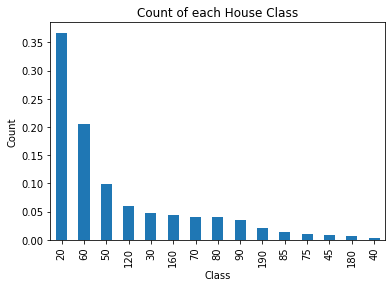

In [23]:
train_df['MSSubClass'] = train_df['MSSubClass'].astype('object')

train_df['MSSubClass'].value_counts(normalize=True).plot(kind='bar')
plt.title("Count of each House Class")
plt.xlabel('Class')
plt.ylabel('Count');

### YearBuilt Analysis

<AxesSubplot:>

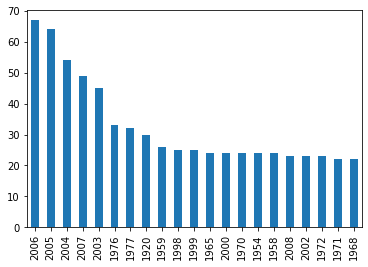

In [24]:
(train_df['YearBuilt'].value_counts()
 [train_df['YearBuilt'].value_counts() > 20]
).plot(kind='bar')

### YearRemodAdd Analysis

In [25]:
train_df['time_taken_to_remodel'] = train_df['YearRemodAdd'] - train_df['YearBuilt']
train_df['time_taken_to_remodel'].describe()

count    1460.000000
mean       13.597945
std        24.476465
min         0.000000
25%         0.000000
50%         0.000000
75%        20.000000
max       123.000000
Name: time_taken_to_remodel, dtype: float64

In [26]:
train_df['time_taken_to_sell'] = train_df['YrSold'] - train_df['YearBuilt']
train_df['time_taken_to_sell'].describe()

count    1460.000000
mean       36.547945
std        30.250152
min         0.000000
25%         8.000000
50%        35.000000
75%        54.000000
max       136.000000
Name: time_taken_to_sell, dtype: float64

In [27]:
train_df['time_taken_to_sell_after_remodel'] = train_df['YrSold'] - train_df['YearRemodAdd']
train_df['time_taken_to_sell_after_remodel'].describe()

count    1460.000000
mean       22.950000
std        20.640653
min        -1.000000
25%         4.000000
50%        14.000000
75%        41.000000
max        60.000000
Name: time_taken_to_sell_after_remodel, dtype: float64

on average it took **36 Years** to sell a house and **22 Year** to sell a house that has been **ReModeled**

### LotArea Analysis

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64


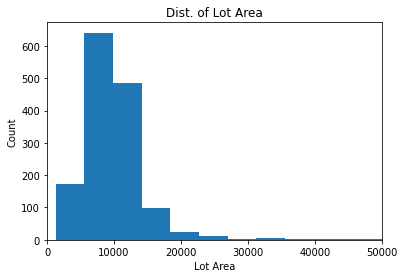

In [28]:
train_df['LotArea'].plot(kind='hist', bins=50)
plt.title("Dist. of Lot Area")
plt.xlabel("Lot Area")
plt.ylabel('Count')
plt.xlim([0, 50_000]);

print(train_df['LotArea'].describe())


most of the houses has a Lot Area around **5,000** to **15,000** square feet

### TotalBsmtSF

count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64


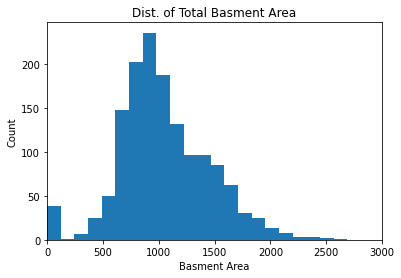

In [29]:
print(train_df['TotalBsmtSF'].describe())

train_df['TotalBsmtSF'].plot(kind='hist', bins=50)
plt.title("Dist. of Total Basment Area")
plt.xlabel("Basment Area")
plt.ylabel('Count');

plt.xlim([0, 3000]);

most of the houses has a Basment Area from **500** to **1500**

### Bedroom and Bathroom Analysis

In [30]:
train_df['BedroomAbvGr'].value_counts()

3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

In [31]:
train_df['FullBath'].value_counts()

2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64

most of the house have a **3, 2 or 4** bedrooms above the grade
and **2 or 1** bathroom above the grade

### OverallQual and OverallCond Analysis

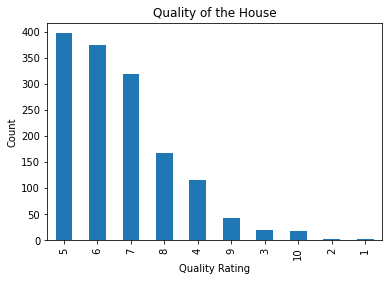

In [32]:
train_df['OverallQual'].value_counts().plot(kind='bar');
plt.title("Quality of the House")
plt.xlabel("Quality Rating")
plt.ylabel("Count");

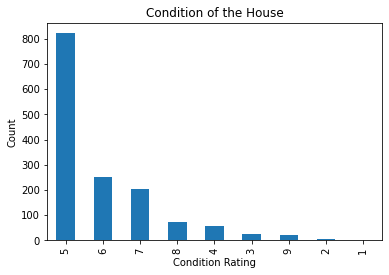

In [33]:
train_df['OverallCond'].value_counts().plot(kind='bar')
plt.title("Condition of the House")
plt.xlabel("Condition Rating")
plt.ylabel("Count");

most of the houses have a rating condition and quality around **5 or 6**

### SalePrice Analysis

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


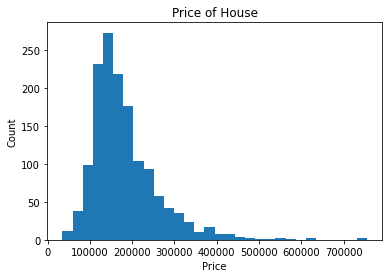

In [34]:
print(train_df['SalePrice'].describe())

train_df['SalePrice'].plot(kind='hist', bins=30)
plt.title("Price of House")
plt.xlabel("Price")
plt.ylabel("Count");

most houses has price ranging between **1,000,000** to **2,500,000** us dollars

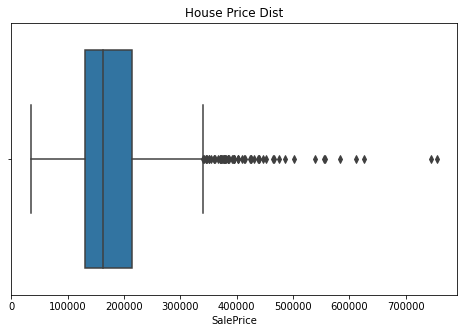

In [35]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=train_df, x='SalePrice')
plt.title("House Price Dist");

### Corrletation Matrix in the Dataset

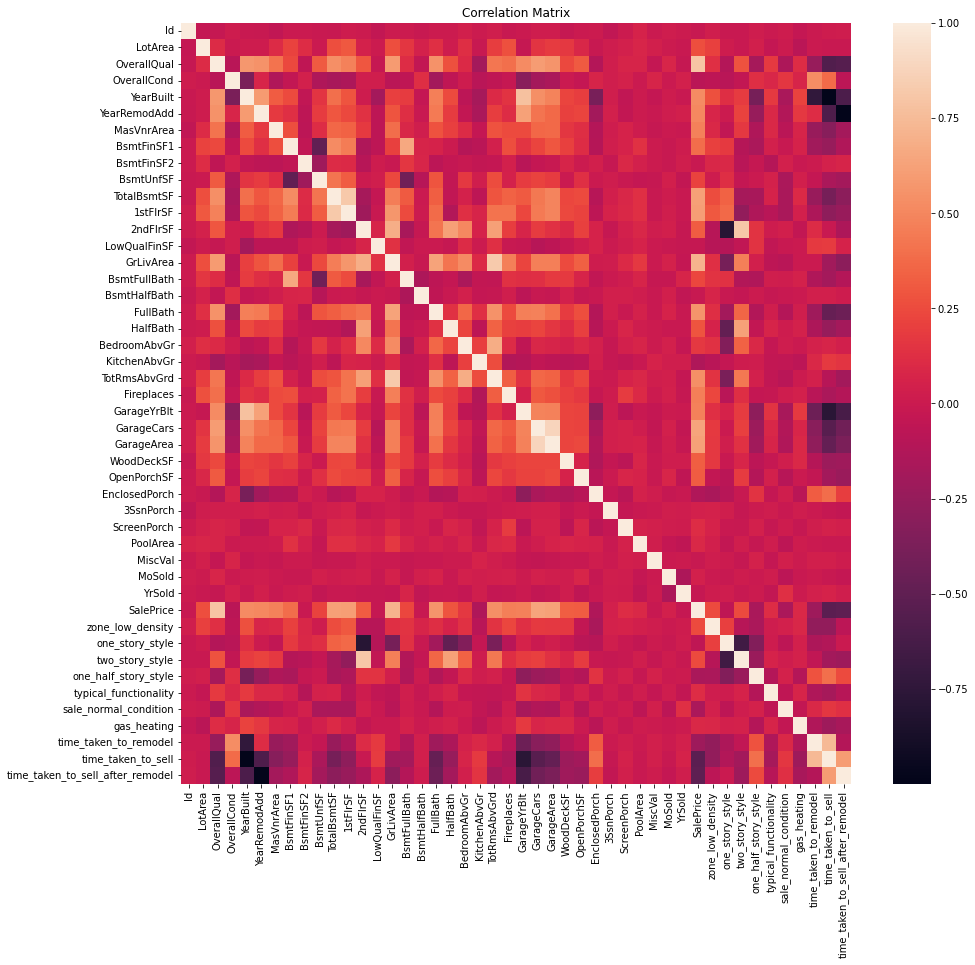

In [36]:
corr = train_df.corr()

fig, ax = plt.subplots(nrows=1, figsize=(15, 14))
sns.heatmap(corr, ax=ax)
ax.set_title("Correlation Matrix");

### SalePrice vs OverallCond

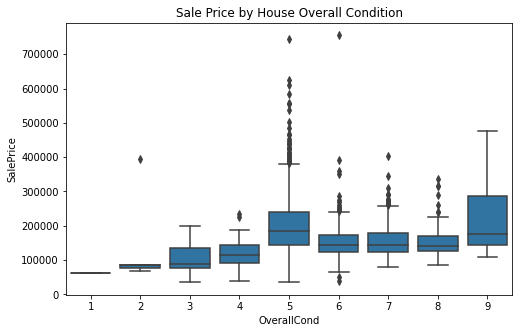

In [37]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=train_df, x='OverallCond', y='SalePrice', color=BASE_COLOR);
plt.title("Sale Price by House Overall Condition");

### SalePrice vs TotalBsmtSF

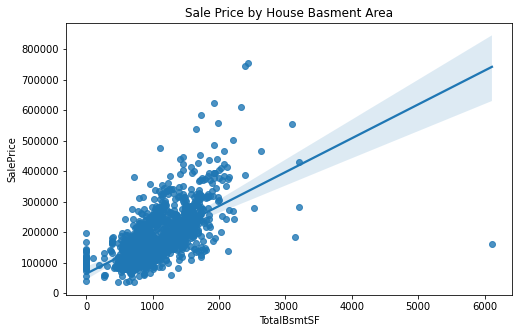

In [38]:
plt.figure(figsize=(8, 5))
sns.regplot(data=train_df, x='TotalBsmtSF', y='SalePrice', color=BASE_COLOR);
plt.title("Sale Price by House Basment Area");

the relation shows existance of outlier point at **6000** so, it would be better it we remove it

In [39]:
train_df.drop(train_df[train_df['TotalBsmtSF'] > 5000].index, inplace=True)
train_df[train_df['TotalBsmtSF'] > 5000]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,zone_low_density,one_story_style,two_story_style,one_half_story_style,typical_functionality,sale_normal_condition,gas_heating,time_taken_to_remodel,time_taken_to_sell,time_taken_to_sell_after_remodel


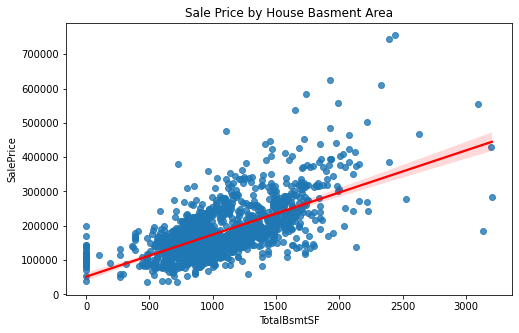

In [40]:
plt.figure(figsize=(8, 5))
sns.regplot(data=train_df, x='TotalBsmtSF', y='SalePrice', line_kws=dict(color='r'));
plt.title("Sale Price by House Basment Area");

### SalePrice vs GrLivArea

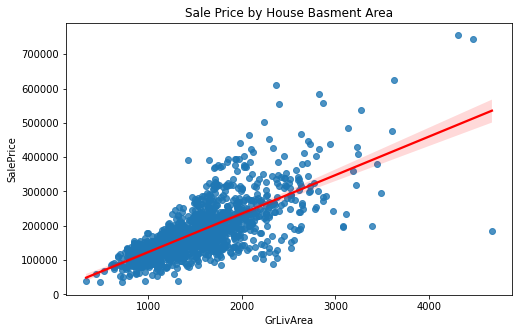

In [41]:
plt.figure(figsize=(8, 5))
sns.regplot(data=train_df,  x='GrLivArea', y='SalePrice', line_kws=dict(color='r'));
plt.title("Sale Price by House Basment Area");

there is outliers in the GrLivArea greater than **4000** so removing it

In [42]:
train_df.drop(train_df[train_df['GrLivArea'] > 4000].index, inplace=True)
train_df[train_df['GrLivArea'] > 4000]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,zone_low_density,one_story_style,two_story_style,one_half_story_style,typical_functionality,sale_normal_condition,gas_heating,time_taken_to_remodel,time_taken_to_sell,time_taken_to_sell_after_remodel


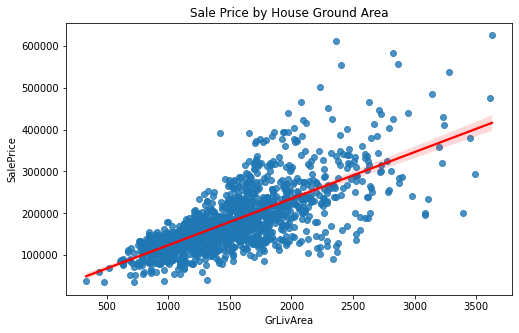

In [43]:
plt.figure(figsize=(8, 5))
sns.regplot(data=train_df, x='GrLivArea', y='SalePrice', line_kws=dict(color='r'));
plt.title("Sale Price by House Ground Area");

### GarageArea vs SalePrice

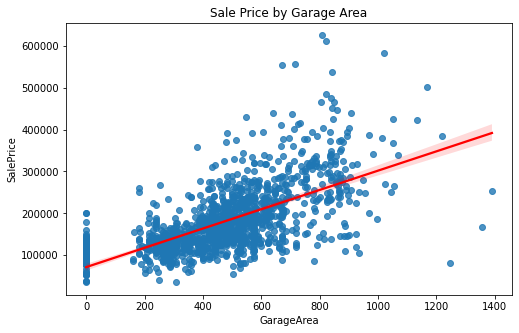

In [44]:
plt.figure(figsize=(8, 5))
sns.regplot(data=train_df, x='GarageArea', y='SalePrice', line_kws=dict(color='r'));
plt.title("Sale Price by Garage Area");

positive correlation indicating an increase in price as the garage area increases.

### GarageCars vs SalePrice

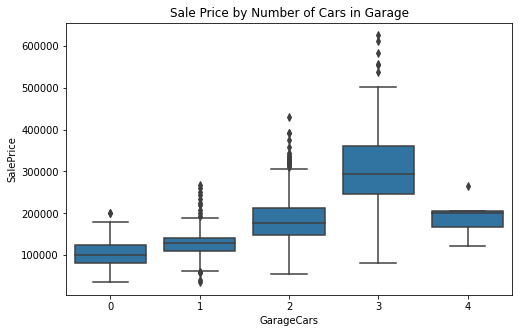

In [45]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=train_df, x='GarageCars', y='SalePrice', color=BASE_COLOR);
plt.title("Sale Price by Number of Cars in Garage");

positive correlation indicating an increase in price as number of cars garage can fit increases

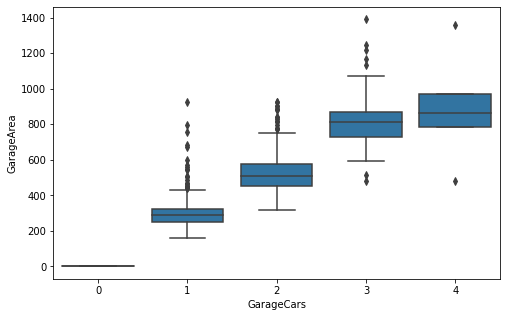

In [46]:
## GarageCars vs GarageArea
## False correlation or colinearity in the dataset
## Does make sense

plt.figure(figsize=(8, 5))
sns.boxplot(data=train_df, x='GarageCars', y='GarageArea', color=BASE_COLOR);

### SalePrice vs FullBath

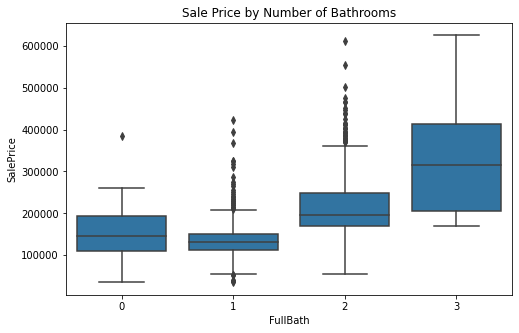

In [47]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=train_df, x='FullBath', y='SalePrice', color=BASE_COLOR);
plt.title("Sale Price by Number of Bathrooms");

# Statmodels OLS Model Analysis

In [48]:
ols_df = train_df.select_dtypes('number')
ols_df.head()

,Id,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,zone_low_density,one_story_style,two_story_style,one_half_story_style,typical_functionality,sale_normal_condition,gas_heating,time_taken_to_remodel,time_taken_to_sell,time_taken_to_sell_after_remodel
0,1,8450,7,5,2003,2003,196.0,706,0,150,...,1,0,1,0,1,1,1,0,5,5
1,2,9600,6,8,1976,1976,0.0,978,0,284,...,1,1,0,0,1,1,1,0,31,31
2,3,11250,7,5,2001,2002,162.0,486,0,434,...,1,0,1,0,1,1,1,1,7,6
3,4,9550,7,5,1915,1970,0.0,216,0,540,...,1,0,1,0,1,0,1,55,91,36
4,5,14260,8,5,2000,2000,350.0,655,0,490,...,1,0,1,0,1,1,1,0,8,8


In [49]:
ols_df = ols_df.drop(['YrSold', 'YearBuilt', 'YearRemodAdd', 'Id'], axis='columns')
ols_df

,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,zone_low_density,one_story_style,two_story_style,one_half_story_style,typical_functionality,sale_normal_condition,gas_heating,time_taken_to_remodel,time_taken_to_sell,time_taken_to_sell_after_remodel
0,8450,7,5,196.0,706,0,150,856,856,854,...,1,0,1,0,1,1,1,0,5,5
1,9600,6,8,0.0,978,0,284,1262,1262,0,...,1,1,0,0,1,1,1,0,31,31
2,11250,7,5,162.0,486,0,434,920,920,866,...,1,0,1,0,1,1,1,1,7,6
3,9550,7,5,0.0,216,0,540,756,961,756,...,1,0,1,0,1,0,1,55,91,36
4,14260,8,5,350.0,655,0,490,1145,1145,1053,...,1,0,1,0,1,1,1,0,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,6,5,0.0,0,0,953,953,953,694,...,1,0,1,0,1,1,1,1,8,7
1456,13175,6,6,119.0,790,163,589,1542,2073,0,...,1,1,0,0,0,1,1,10,32,22
1457,9042,7,9,0.0,275,0,877,1152,1188,1152,...,1,0,1,0,1,1,1,65,69,4
1458,9717,5,6,0.0,49,1029,0,1078,1078,0,...,1,1,0,0,1,1,1,46,60,14


In [50]:
ols_df['intercept'] = 1

In [51]:
ols_model = OLS(ols_df['SalePrice'], ols_df.drop('SalePrice', axis='columns'))
result = ols_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     248.8
Date:                Sun, 01 May 2022   Prob (F-statistic):               0.00
Time:                        01:35:18   Log-Likelihood:                -16959.
No. Observations:                1456   AIC:                         3.400e+04
Df Residuals:                    1417   BIC:                         3.420e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
LotArea                              0.5892      0.082      7.168      0.000       0.428       0.750
OverallQual                         1.4e+04    980.392     14.279      0.000    1.21e+04    1.59e+04
OverallCond                       4810.6610    864.986      5.562      0.000    3113.871    6507.451
MasVnrArea                          28.7187      4.871      5.896      0.000      19.163      38.274
BsmtFinSF1                          20.2892      2.144      9.464      0.000      16.084      24.495
BsmtFinSF2                           0.3289      3.650      0.090      0.928      -6.830       7.488
BsmtUnfSF                           -0.2817      1.969     -0.143      0.886      -4.145       3.582
TotalBsmtSF                         20.3364      2.826      7.196      0.000      14.793      25.880
1stFlrSF                            23.5409      5.308      4.435      0.000      13.129      33.953
2ndFlrSF                            28.9580      5.521      5.245      0.000      18.128      39.788
LowQualFinSF                       -18.3571     12.279     -1.495      0.135     -42.445       5.730
GrLivArea                           34.1418      4.674      7.305      0.000      24.974      43.310
BsmtFullBath                      1188.0415   2142.964      0.554      0.579   -3015.682    5391.765
BsmtHalfBath                     -6472.7349   3345.912     -1.935      0.053    -1.3e+04      90.739
FullBath                         -1839.3572   2303.181     -0.799      0.425   -6357.367    2678.653
HalfBath                         -1745.3871   2214.303     -0.788      0.431   -6089.052    2598.278
BedroomAbvGr                     -1.179e+04   1379.653     -8.545      0.000   -1.45e+04   -9082.100
KitchenAbvGr                     -2.403e+04   3983.327     -6.034      0.000   -3.18e+04   -1.62e+04
TotRmsAbvGrd                      5593.5981   1013.354      5.520      0.000    3605.763    7581.433
Fireplaces                        1842.6362   1457.101      1.265      0.206   -1015.671    4700.943
GarageYrBlt                        106.9927     56.099      1.907      0.057      -3.053     217.038
GarageCars                        3023.0111   2356.422      1.283      0.200   -1599.439    7645.461
GarageArea                          18.5384      8.052      2.302      0.021       2.743      34.334
WoodDeckSF                          15.2935      6.518      2.346      0.019       2.508      28.079
OpenPorchSF                         27.3756     12.513      2.188      0.029       2.829      51.922
EnclosedPorch                       11.2541     13.682      0.823      0.411     -15.585      38.093
3SsnPorch                           10.4082     25.354      0.411      0.681     -39.328      60.144
ScreenPorch                         38.0293     13.97

# Sklearn Models Analysis

In [52]:
features_cols = [
    "time_taken_to_sell",
    "OverallQual",
    "OverallCond",
    "MasVnrArea",
    "TotalBsmtSF",
    "GrLivArea",
    "BedroomAbvGr",
    "TotRmsAbvGrd",
    "GarageArea",
    "ScreenPorch",
    "zone_low_density",
    "typical_functionality",
    "sale_normal_condition",
]

In [53]:
features_df = train_df[features_cols]
features_df.head()

,time_taken_to_sell,OverallQual,OverallCond,MasVnrArea,TotalBsmtSF,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,GarageArea,ScreenPorch,zone_low_density,typical_functionality,sale_normal_condition
0,5,7,5,196.0,856,1710,3,8,548,0,1,1,1
1,31,6,8,0.0,1262,1262,3,6,460,0,1,1,1
2,7,7,5,162.0,920,1786,3,6,608,0,1,1,1
3,91,7,5,0.0,756,1717,3,7,642,0,1,1,0
4,8,8,5,350.0,1145,2198,4,9,836,0,1,1,1


In [54]:
X = features_df.values
y = train_df['SalePrice']

In [55]:
sc = StandardScaler()

X = sc.fit_transform(X)
X

array([[-1.04612544,  0.66564559, -0.51746143, ...,  0.51903606,
         0.27156272,  0.46516048],
       [-0.18625648, -0.06470858,  2.17654515, ...,  0.51903606,
         0.27156272,  0.46516048],
       [-0.97998167,  0.66564559, -0.51746143, ...,  0.51903606,
         0.27156272,  0.46516048],
       ...,
       [ 1.07047507,  0.66564559,  3.07454735, ...,  0.51903606,
         0.27156272,  0.46516048],
       [ 0.77282812, -0.79506274,  0.38054077, ...,  0.51903606,
         0.27156272,  0.46516048],
       [ 0.21060611, -0.79506274,  0.38054077, ...,  0.51903606,
         0.27156272,  0.46516048]])

In [56]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

assert x_train.shape[1] == x_test.shape[1]

## Linear Model

In [57]:
lm = LinearRegression()
lm.fit(x_train, y_train)
lm_preds = lm.predict(x_test)

print("R2 Score for Linear Model : ", lm.score(x_test, y_test))
print("RMSE for Linear Model : ", np.sqrt(mean_squared_error(y_test, lm_preds)))

R2 Score for Linear Model :  0.8464733772982462
RMSE for Linear Model :  28386.122329701033


## RandomForest Model

In [58]:
rf_model = RandomForestRegressor()
rf_model.fit(x_train, y_train)
rf_preds = rf_model.predict(x_test)

print("R2 Score for Random Forest Model : ", rf_model.score(x_test, y_test))
print("RMSE for Random Forest Model : ", np.sqrt(mean_squared_error(y_test, rf_preds)))

R2 Score for Random Forest Model :  0.8718567738601649
RMSE for Random Forest Model :  25933.554655943077


## DecisionTreeRegressor Model

In [59]:
dt_model = DecisionTreeRegressor()
dt_model.fit(x_train, y_train)
dt_preds = dt_model.predict(x_test)

print("R2 Score for Decision Tree Model : ", rf_model.score(x_test, y_test))
print("RMSE for Decision Tree Model : ", np.sqrt(mean_squared_error(y_test, dt_preds)))

R2 Score for Decision Tree Model :  0.8718567738601649
RMSE for Decision Tree Model :  39583.2371666652


**Random Forest Model** is the best till this moment with **RMSE = 25126.752** and **R2 = 0.8797** and I will use to predict the test dataframe

## Generating Prediction on Test DataFrame

### Cleaning Test Dataset like in Train Dataset

In [60]:
## MSZoning Column
test_df['zone_low_density'] = test_df['MSZoning'] == "RL"

## HouseStyle Column
test_df['one_story_style'] = test_df['HouseStyle'] == '1Story'
test_df['two_story_style'] = test_df['HouseStyle'] == '2Story'
test_df['one_half_story_style'] = test_df['HouseStyle'] == '1.5Fin'

## Functional Column
test_df['typical_functionality'] = test_df['Functional'] == 'Typ'

## Sale Condition
test_df['sale_normal_condition'] = test_df['SaleCondition'] == 'Normal'

## Heating Column
test_df['gas_heating'] = test_df['Heating'] == 'GasA'

## conver to numeric values
cols = ['zone_low_density', 'one_story_style', 'two_story_style', 'typical_functionality',
        'one_half_story_style', 'gas_heating', 'sale_normal_condition']

test_df[cols] = test_df[cols].astype('int')

# test_df[
#     ['zone_low_density', 'one_story_style', 'two_story_style', 'typical_functionality',
#      'one_half_story_style', 'gas_heating', 'sale_normal_condition']
# ].head()

In [61]:
test_df['time_taken_to_sell'] = test_df['YrSold'] - test_df['YearBuilt']

In [62]:
test_features_df = test_df[features_cols]
test_features_df.head()

,time_taken_to_sell,OverallQual,OverallCond,MasVnrArea,TotalBsmtSF,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,GarageArea,ScreenPorch,zone_low_density,typical_functionality,sale_normal_condition
0,49,5,6,0.0,882.0,896,2,5,730.0,120,0,1,1
1,52,6,6,108.0,1329.0,1329,3,6,312.0,0,1,1,1
2,13,5,5,0.0,928.0,1629,3,6,482.0,0,1,1,1
3,12,6,6,20.0,926.0,1604,3,7,470.0,0,1,1,1
4,18,8,5,0.0,1280.0,1280,2,5,506.0,144,1,1,1


In [63]:
test_features_df.isna().sum()

time_taken_to_sell        0
OverallQual               0
OverallCond               0
MasVnrArea               15
TotalBsmtSF               1
GrLivArea                 0
BedroomAbvGr              0
TotRmsAbvGrd              0
GarageArea                1
ScreenPorch               0
zone_low_density          0
typical_functionality     0
sale_normal_condition     0
dtype: int64

In [64]:
test_features_df['MasVnrArea'].fillna(test_features_df['MasVnrArea'].mean(), inplace=True)
test_features_df['TotalBsmtSF'].fillna(test_features_df['TotalBsmtSF'].mean(), inplace=True)
test_features_df['GarageArea'].fillna(test_features_df['GarageArea'].mean(), inplace=True)

assert len(test_features_df.isna().sum()[test_features_df.isna().sum() != 0]) == 0

In [65]:
X_test = test_features_df.values
X_test = sc.fit_transform(X_test)
X_test

array([[ 0.41378443, -0.75110125,  0.40076604, ..., -1.79693781,
         0.27416383,  0.46021084],
       [ 0.51239787, -0.05487716,  0.40076604, ...,  0.55650229,
         0.27416383,  0.46021084],
       [-0.76957685, -0.75110125, -0.49741776, ...,  0.55650229,
         0.27416383,  0.46021084],
       ...,
       [ 0.31517099, -0.75110125,  1.29894985, ...,  0.55650229,
         0.27416383, -2.17291708],
       [-0.73670571, -0.75110125, -0.49741776, ...,  0.55650229,
         0.27416383,  0.46021084],
       [-0.76957685,  0.64134693, -0.49741776, ...,  0.55650229,
         0.27416383,  0.46021084]])

### Evaluating Best Machine Learning Model.

In [66]:
test_preds = rf_model.predict(X_test)
test_preds

array([129459.  , 154134.5 , 172650.33, ..., 151392.5 , 113305.  ,
       233236.3 ])

In [67]:
test_df['SalePrice'] = test_preds
test_df[['Id', 'SalePrice']].head()

,Id,SalePrice
0,1461,129459.00
1,1462,154134.50
2,1463,172650.33
3,1464,190920.00
4,1465,210673.91


In [68]:
## exporting the predictions to csv
test_df[['Id', 'SalePrice']].to_csv('./predictions/predictions_1.csv', index=False)

## PyTorch Neural Network Model

In [69]:
class HouseDataset(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        """
        Args:
            x_data (np.ndarray) : x_train data array
            y_data (np.ndarray) : y_train data array
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform
        
    def __len__(self):
        return self.x_data.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        if not isinstance(self.y_data, np.ndarray):
            self.y_data = np.array(self.y_data)
        
        x_sample = self.x_data[idx]
        y_sample = self.y_data[idx]
        
        if self.transform is not None:
            x_sample = self.transform(x_sample)
            
        return x_sample, y_sample
    
    
train_ds = HouseDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

sample = next(iter(train_dl))
sample[0], sample[1]

(tensor([[ 1.4673e+00,  6.6565e-01,  1.2785e+00, -5.7750e-01, -7.8313e-01,
           2.7081e-01,  1.6591e-01, -3.1416e-01,  3.5123e-01, -2.7061e-01,
          -1.9266e+00,  2.7156e-01,  4.6516e-01],
         [-1.0131e+00,  2.8567e+00, -5.1746e-01,  3.4103e+00,  3.8405e+00,
           2.2682e+00, -1.0603e+00,  9.2712e-01,  1.5687e+00, -2.7061e-01,
           5.1904e-01,  2.7156e-01,  4.6516e-01],
         [ 5.0825e-01, -7.9506e-01, -5.1746e-01, -5.7750e-01, -2.5501e+00,
          -7.7017e-01,  1.6591e-01, -9.3479e-01, -2.2253e+00, -2.7061e-01,
           5.1904e-01, -3.6824e+00,  4.6516e-01],
         [ 7.8319e-02, -7.9506e-01,  3.8054e-01, -1.4761e-01, -1.1810e-01,
          -1.0158e+00,  1.6591e-01, -9.3479e-01,  2.0312e+00, -2.7061e-01,
           5.1904e-01,  2.7156e-01,  4.6516e-01],
         [ 1.4673e+00, -7.9506e-01,  1.2785e+00, -5.7750e-01, -3.0256e-01,
          -3.8358e-01,  1.6591e-01, -3.1416e-01,  5.8662e-02, -2.7061e-01,
          -1.9266e+00,  2.7156e-01,  4.6516e-01],


In [70]:
class NNet(nn.Module):
    def __init__(self, input_size: int, hidden_sizes: list, output_size: int=1) -> None:
        super().__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        out = self.fc4(x)
        
        return out

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.mse = nn.MSELoss()
    
    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))


In [71]:
def train(train_dl, model, optimizer, criterion, epochs=100) -> list:
    losses = []

    print("{:<8}|{:>15}".format("Epoch", "Loss"))
    print("="*24)
    epoch_loss = 0
    
    for epoch in range(epochs):
        epoch_losses = []
        for x_batch, y_batch in train_dl:
            
            y_preds = model(x_batch.float())
            loss = criterion(y_preds, y_batch.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_losses.append(loss.item())
        
        losses.append(np.mean(epoch_losses))
        
        if epoch % 10 == 0:
            print("{:<8}|{:>15}".format(epoch, round(np.mean(epoch_losses), 3)))

    return losses


In [72]:
## initializing mode
n_feaures = x_train.shape[1]
hidden_sizes = [32, 16, 8]
output_size = 1

model = NNet(n_feaures, hidden_sizes, output_size)

print(model)

## training Model
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = RMSELoss()

losses = train(train_dl, model, optimizer, criterion, epochs=200)

NNet(
  (fc1): Linear(in_features=13, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
)
Epoch   |           Loss
0       |     196045.524
10      |      79553.088
20      |      76881.525
30      |      75187.745
40      |      75267.642
50      |       76417.62
60      |      75412.843
70      |      75768.498
80      |      76077.083
90      |      75788.585
100     |      75680.965
110     |      75396.359
120     |      76147.532
130     |      74582.772
140     |      76748.031
150     |       76243.72
160     |      76572.471
170     |      75917.212
180     |      76640.626
190     |      75758.835


(70000.0, 90000.0)

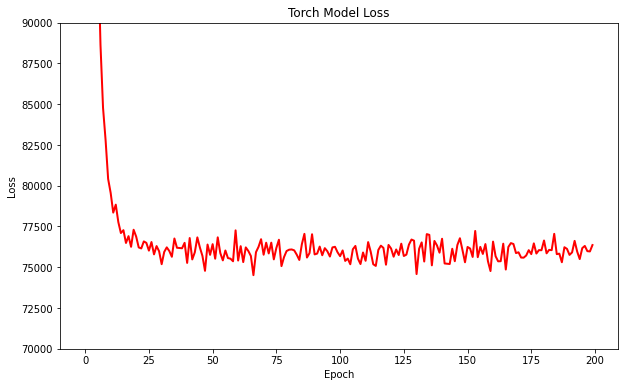

In [73]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, figsize=(10, 6))

ax.plot(losses, 'r-', lw=2)
ax.set_title("Torch Model Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss");
ax.set_ylim([70000, 90000])